In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
df = pd.read_csv('citibike_data/citibike_2018.csv')

### Confusion Matrix function: 

In [30]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    plt.figure(figsize=(20,12))
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

### Test of dropping tripduration:

In [18]:
df = df.drop('tripduration', axis=1)

In [19]:
df_small = df.sample(15000)

Split variables from targets: 

In [20]:
labels = df_small.stop_nhbr

Use LabelEncoder to convert target labels into a categories: 

In [21]:
le = LabelEncoder()

In [22]:
labels = le.fit_transform(labels.astype(str))
labels_removed_df = df_small.drop('stop_nhbr', axis=1)

Scale data: 

In [23]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(labels_removed_df.astype(float))

Split data into training and testing sets.  Maintain at least some of each target class in both sets with the 'stratify' argument. 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, labels, stratify=labels )

Fit xgboost model: 

In [25]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=2, min_child_weight=4, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=2, min_child_weight=4, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [27]:
training_preds = clf.predict(X_train)

In [28]:
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 35.4%
Validation accuracy: 5.867%


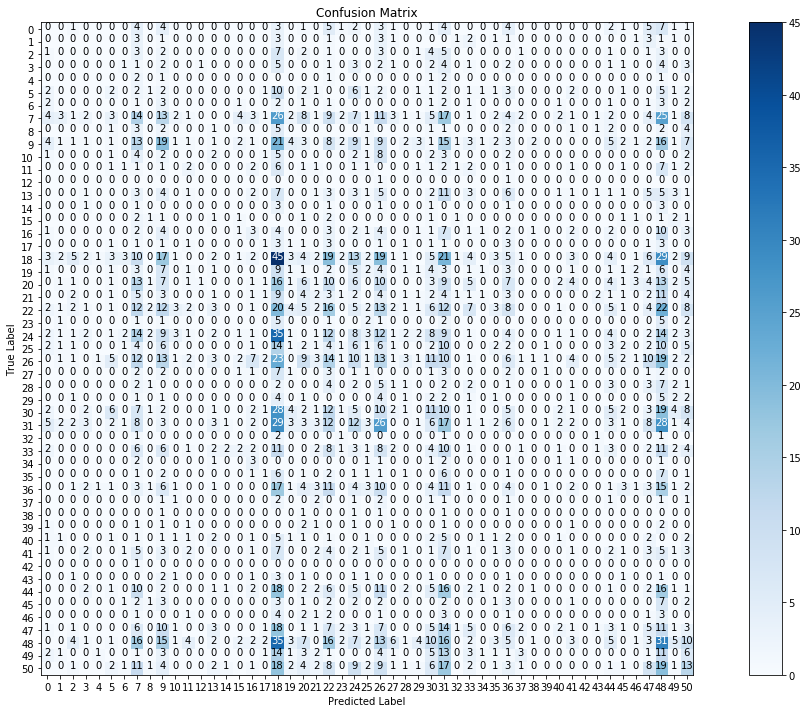

In [31]:
show_cf(y_test, val_preds)

In [14]:
param_grid = {
    "learning_rate": [0.5, 0.7, 0.1],
    'max_depth': [2, 3, 4],
    'min_child_weight': [4, 5],
    'n_estimators': [300, 400, 500],
}

In [15]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
eval_metric = ["auc", 'error']
eval_set = [(X_train, y_train), (X_test, y_test)]
grid_clf.fit(X_train, y_train, eval_set= eval_set, early_stopping_rounds=5)
best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[0]	validation_0-merror:0.929511	validation_1-merror:0.941067
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.922933	validation_1-merror:0.939467
[2]	validation_0-merror:0.9192	validation_1-merror:0.94
[3]	validation_0-merror:0.916	validation_1-merror:0.943467
[4]	validation_0-merror:0.914044	validation_1-merror:0.9432
[5]	validation_0-merror:0.911911	validation_1-merror:0.9392
[6]	validation_0-merror:0.908978	validation_1-merror:0.940267
[7]	validation_0-merror:0.9088	validation_1-merror:0.943733
[8]	validation_0-merror:0.907733	validation_1-merror:0.942933
[9]	validation_0-merror:0.905689	validation_1-merror:0.9416
[10]	validation_0-merror:0.904444	validation_1-merror:0.944
Stopping. Best iteration:
[5]	validation_0-merror:0.911911	validation_1-merror:0.9392

[0]	validation_0-merror:0.925422	validation_1-merror:0.932267
Multiple eval metrics have

[5]	validation_0-merror:0.912267	validation_1-merror:0.9304
[6]	validation_0-merror:0.911556	validation_1-merror:0.931733
[7]	validation_0-merror:0.910044	validation_1-merror:0.9352
[8]	validation_0-merror:0.905956	validation_1-merror:0.936
[9]	validation_0-merror:0.903378	validation_1-merror:0.9368
[10]	validation_0-merror:0.902311	validation_1-merror:0.936267
Stopping. Best iteration:
[5]	validation_0-merror:0.912267	validation_1-merror:0.9304

[0]	validation_0-merror:0.929511	validation_1-merror:0.939733
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.921867	validation_1-merror:0.935467
[2]	validation_0-merror:0.919467	validation_1-merror:0.9408
[3]	validation_0-merror:0.915022	validation_1-merror:0.938933
[4]	validation_0-merror:0.915644	validation_1-merror:0.938667
[5]	validation_0-merror:0.9144	validation_1-merror:0.938933
[6]	validation_0-me

[5]	validation_0-merror:0.896089	validation_1-merror:0.937333
[6]	validation_0-merror:0.893511	validation_1-merror:0.938667
Stopping. Best iteration:
[1]	validation_0-merror:0.909956	validation_1-merror:0.9352

[0]	validation_0-merror:0.924356	validation_1-merror:0.939467
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.917156	validation_1-merror:0.9392
[2]	validation_0-merror:0.911111	validation_1-merror:0.940267
[3]	validation_0-merror:0.904889	validation_1-merror:0.936533
[4]	validation_0-merror:0.899822	validation_1-merror:0.9384
[5]	validation_0-merror:0.898222	validation_1-merror:0.939733
[6]	validation_0-merror:0.896533	validation_1-merror:0.936
[7]	validation_0-merror:0.892533	validation_1-merror:0.934133
[8]	validation_0-merror:0.888	validation_1-merror:0.9344
[9]	validation_0-merror:0.885067	validation_1-merror:0.9336
[10]	validation_0-mer

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.918844	validation_1-merror:0.9368
[2]	validation_0-merror:0.912444	validation_1-merror:0.934133
[3]	validation_0-merror:0.904533	validation_1-merror:0.938133
[4]	validation_0-merror:0.899378	validation_1-merror:0.937333
[5]	validation_0-merror:0.897067	validation_1-merror:0.937333
[6]	validation_0-merror:0.894844	validation_1-merror:0.937333
[7]	validation_0-merror:0.893156	validation_1-merror:0.936267
Stopping. Best iteration:
[2]	validation_0-merror:0.912444	validation_1-merror:0.934133

[0]	validation_0-merror:0.919733	validation_1-merror:0.936
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.910933	validation_1-merror:0.929867
[2]	validation_0-merror:0.9072	validation_1-merror:0.932267
[3]	validation_0-merror:0.901333	validation_1-merror:0.9296
[4]	valida

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.897689	validation_1-merror:0.9352
[2]	validation_0-merror:0.892089	validation_1-merror:0.934667
[3]	validation_0-merror:0.886311	validation_1-merror:0.937067
[4]	validation_0-merror:0.8832	validation_1-merror:0.937333
[5]	validation_0-merror:0.877067	validation_1-merror:0.939467
[6]	validation_0-merror:0.870578	validation_1-merror:0.940533
[7]	validation_0-merror:0.864444	validation_1-merror:0.941333
Stopping. Best iteration:
[2]	validation_0-merror:0.892089	validation_1-merror:0.934667

[0]	validation_0-merror:0.915022	validation_1-merror:0.943733
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.903289	validation_1-merror:0.937067
[2]	validation_0-merror:0.895111	validation_1-merror:0.936
[3]	validation_0-merror:0.8864	validation_1-merror:0.9392
[4]	validati

[5]	validation_0-merror:0.876622	validation_1-merror:0.94
[6]	validation_0-merror:0.869244	validation_1-merror:0.9424
[7]	validation_0-merror:0.867467	validation_1-merror:0.945067
Stopping. Best iteration:
[2]	validation_0-merror:0.893511	validation_1-merror:0.9368

[0]	validation_0-merror:0.914933	validation_1-merror:0.940267
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.904356	validation_1-merror:0.937333
[2]	validation_0-merror:0.896444	validation_1-merror:0.9392
[3]	validation_0-merror:0.892	validation_1-merror:0.940267
[4]	validation_0-merror:0.886311	validation_1-merror:0.938133
[5]	validation_0-merror:0.880889	validation_1-merror:0.939467
[6]	validation_0-merror:0.873956	validation_1-merror:0.9368
[7]	validation_0-merror:0.870933	validation_1-merror:0.936533
[8]	validation_0-merror:0.868267	validation_1-merror:0.9384
[9]	validation_0-merro

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.922133	validation_1-merror:0.941067
[2]	validation_0-merror:0.917956	validation_1-merror:0.937333
[3]	validation_0-merror:0.914933	validation_1-merror:0.935467
[4]	validation_0-merror:0.913956	validation_1-merror:0.9392
[5]	validation_0-merror:0.909333	validation_1-merror:0.938667
[6]	validation_0-merror:0.908978	validation_1-merror:0.9392
[7]	validation_0-merror:0.906044	validation_1-merror:0.938133
[8]	validation_0-merror:0.905511	validation_1-merror:0.934933
[9]	validation_0-merror:0.9016	validation_1-merror:0.932533
[10]	validation_0-merror:0.900267	validation_1-merror:0.931733
[11]	validation_0-merror:0.898667	validation_1-merror:0.931733
[12]	validation_0-merror:0.897244	validation_1-merror:0.932533
[13]	validation_0-merror:0.896444	validation_1-merror:0.934667
[14]	validation_0-merror:0.894311	validation_1-merror:0.933867
[15]	validation_0-merror:0.892089	validation_1-merror:0.9328
Stoppi

Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.922311	validation_1-merror:0.935467
[2]	validation_0-merror:0.915022	validation_1-merror:0.928
[3]	validation_0-merror:0.914222	validation_1-merror:0.9304
[4]	validation_0-merror:0.9112	validation_1-merror:0.929867
[5]	validation_0-merror:0.9088	validation_1-merror:0.9328
[6]	validation_0-merror:0.908711	validation_1-merror:0.932267
[7]	validation_0-merror:0.904711	validation_1-merror:0.9352
Stopping. Best iteration:
[2]	validation_0-merror:0.915022	validation_1-merror:0.928

[0]	validation_0-merror:0.920444	validation_1-merror:0.936267
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.910844	validation_1-merror:0.937067
[2]	validation_0-merror:0.906578	validation_1

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.913333	validation_1-merror:0.9376
[2]	validation_0-merror:0.906578	validation_1-merror:0.9384
[3]	validation_0-merror:0.902489	validation_1-merror:0.941067
[4]	validation_0-merror:0.899111	validation_1-merror:0.939733
[5]	validation_0-merror:0.8976	validation_1-merror:0.941867
Stopping. Best iteration:
[0]	validation_0-merror:0.919644	validation_1-merror:0.935733

[0]	validation_0-merror:0.925067	validation_1-merror:0.939467
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.915911	validation_1-merror:0.939467
[2]	validation_0-merror:0.908978	validation_1-merror:0.94
[3]	validation_0-merror:0.905244	validation_1-merror:0.939733
[4]	validation_0-merror:0.8992	validation_1-merror:0.9376
[5]	validation_0-merror:0.892	validation_1-merror:0.936267
[6]	validation_0-m

[0]	validation_0-merror:0.911556	validation_1-merror:0.9424
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.900711	validation_1-merror:0.9392
[2]	validation_0-merror:0.890222	validation_1-merror:0.9424
[3]	validation_0-merror:0.879467	validation_1-merror:0.944
[4]	validation_0-merror:0.872889	validation_1-merror:0.9392
[5]	validation_0-merror:0.865067	validation_1-merror:0.940267
[6]	validation_0-merror:0.86	validation_1-merror:0.9416
Stopping. Best iteration:
[1]	validation_0-merror:0.900711	validation_1-merror:0.9392

[0]	validation_0-merror:0.915022	validation_1-merror:0.943733
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.902667	validation_1-merror:0.936267
[2]	validation_0-merror:0.893422	validation_1-me

[8]	validation_0-merror:0.857511	validation_1-merror:0.939467
Stopping. Best iteration:
[3]	validation_0-merror:0.889244	validation_1-merror:0.936267

[0]	validation_0-merror:0.917689	validation_1-merror:0.939733
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.908444	validation_1-merror:0.9376
[2]	validation_0-merror:0.898844	validation_1-merror:0.934133
[3]	validation_0-merror:0.890756	validation_1-merror:0.933333
[4]	validation_0-merror:0.884178	validation_1-merror:0.934133
[5]	validation_0-merror:0.878667	validation_1-merror:0.937867
[6]	validation_0-merror:0.871911	validation_1-merror:0.938667
[7]	validation_0-merror:0.862844	validation_1-merror:0.940267
[8]	validation_0-merror:0.855644	validation_1-merror:0.941867
Stopping. Best iteration:
[3]	validation_0-merror:0.890756	validation_1-merror:0.933333

[0]	validation_0-merror:0.914044	validatio

[10]	validation_0-merror:0.916178	validation_1-merror:0.933333
[11]	validation_0-merror:0.915289	validation_1-merror:0.9296
[12]	validation_0-merror:0.914133	validation_1-merror:0.9312
[13]	validation_0-merror:0.913422	validation_1-merror:0.931733
Stopping. Best iteration:
[8]	validation_0-merror:0.916889	validation_1-merror:0.926667

[0]	validation_0-merror:0.925422	validation_1-merror:0.932267
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.926578	validation_1-merror:0.9328
[2]	validation_0-merror:0.924356	validation_1-merror:0.9312
[3]	validation_0-merror:0.923467	validation_1-merror:0.929333
[4]	validation_0-merror:0.923111	validation_1-merror:0.930933
[5]	validation_0-merror:0.923556	validation_1-merror:0.9304
[6]	validation_0-merror:0.922489	validation_1-merror:0.9296
[7]	validation_0-merror:0.921511	validation_1-merror:0.931733
[8]	validatio

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.924622	validation_1-merror:0.9336
[2]	validation_0-merror:0.921156	validation_1-merror:0.9296
[3]	validation_0-merror:0.919644	validation_1-merror:0.929067
[4]	validation_0-merror:0.919022	validation_1-merror:0.930933
[5]	validation_0-merror:0.918311	validation_1-merror:0.928
[6]	validation_0-merror:0.919378	validation_1-merror:0.929867
[7]	validation_0-merror:0.917689	validation_1-merror:0.929333
[8]	validation_0-merror:0.916978	validation_1-merror:0.930933
[9]	validation_0-merror:0.916889	validation_1-merror:0.930933
[10]	validation_0-merror:0.917778	validation_1-merror:0.932533
Stopping. Best iteration:
[5]	validation_0-merror:0.918311	validation_1-merror:0.928

[0]	validation_0-merror:0.929511	validation_1-merror:0.939733
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	valida

[7]	validation_0-merror:0.907289	validation_1-merror:0.932
[8]	validation_0-merror:0.907111	validation_1-merror:0.930667
[9]	validation_0-merror:0.904622	validation_1-merror:0.929867
[10]	validation_0-merror:0.905333	validation_1-merror:0.930933
[11]	validation_0-merror:0.903111	validation_1-merror:0.9328
[12]	validation_0-merror:0.902133	validation_1-merror:0.932
[13]	validation_0-merror:0.899556	validation_1-merror:0.933067
[14]	validation_0-merror:0.898933	validation_1-merror:0.9328
Stopping. Best iteration:
[9]	validation_0-merror:0.904622	validation_1-merror:0.929867

[0]	validation_0-merror:0.919289	validation_1-merror:0.934933
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.912267	validation_1-merror:0.932
[2]	validation_0-merror:0.912178	validation_1-merror:0.932533
[3]	validation_0-merror:0.909422	validation_1-merror:0.929067
[4]	validatio

[3]	validation_0-merror:0.911378	validation_1-merror:0.936533
[4]	validation_0-merror:0.909778	validation_1-merror:0.930933
[5]	validation_0-merror:0.911467	validation_1-merror:0.9328
[6]	validation_0-merror:0.910667	validation_1-merror:0.931733
[7]	validation_0-merror:0.908978	validation_1-merror:0.926933
[8]	validation_0-merror:0.908089	validation_1-merror:0.9288
[9]	validation_0-merror:0.907378	validation_1-merror:0.931467
[10]	validation_0-merror:0.904533	validation_1-merror:0.930933
[11]	validation_0-merror:0.903556	validation_1-merror:0.932
[12]	validation_0-merror:0.902222	validation_1-merror:0.933067
Stopping. Best iteration:
[7]	validation_0-merror:0.908978	validation_1-merror:0.926933

[0]	validation_0-merror:0.919733	validation_1-merror:0.936
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.911289	validation_1-merror:0.930933
[2]	validati

[8]	validation_0-merror:0.8904	validation_1-merror:0.935467
[9]	validation_0-merror:0.887022	validation_1-merror:0.937867
[10]	validation_0-merror:0.8848	validation_1-merror:0.938933
[11]	validation_0-merror:0.8824	validation_1-merror:0.9368
Stopping. Best iteration:
[6]	validation_0-merror:0.893956	validation_1-merror:0.931733

[0]	validation_0-merror:0.911556	validation_1-merror:0.9424
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.908267	validation_1-merror:0.933867
[2]	validation_0-merror:0.902311	validation_1-merror:0.938133
[3]	validation_0-merror:0.901333	validation_1-merror:0.9368
[4]	validation_0-merror:0.8976	validation_1-merror:0.936
[5]	validation_0-merror:0.896356	validation_1-merror:0.935467
[6]	validation_0-merror:0.894133	validation_1-merror:0.935467
Stopping. Best iteration:
[1]	validation_0-merror:0.908267	validation_1-merror:0.9

Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.906311	validation_1-merror:0.9344
[2]	validation_0-merror:0.905333	validation_1-merror:0.9376
[3]	validation_0-merror:0.903467	validation_1-merror:0.938133
[4]	validation_0-merror:0.899733	validation_1-merror:0.934933
[5]	validation_0-merror:0.897778	validation_1-merror:0.935467
[6]	validation_0-merror:0.894756	validation_1-merror:0.9392
Stopping. Best iteration:
[1]	validation_0-merror:0.906311	validation_1-merror:0.9344

[0]	validation_0-merror:0.914933	validation_1-merror:0.940267
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 5 rounds.
[1]	validation_0-merror:0.906844	validation_1-merror:0.933867
[2]	validation_0-merror:0.904711	validation_1-merror:0.9376
[3]	validation_0-merror:0.904089	valida

Grid Search found the following optimal parameters: 
learning_rate: 0.5
max_depth: 2
min_child_weight: 5
n_estimators: 300

Training Accuracy: 10.36%
Validation accuracy: 7.547%


In [ ]:
acc = accuracy_score(y_test, val_preds) * 100

In [ ]:
print(len(val_preds)) 
print(len(y_test))

In [ ]:
cf = confusion_matrix(y_test, val_preds)
cf

In [ ]:


def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

show_cf(y_test, val_preds)